In [1]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
import pickle
import umap

# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 1
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('../report_plots/report.mplstyle')


# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.13.1+cu117
Using device: cuda:1


# Figure 3

In [2]:
mouse_id = 'Mouse12'
session_id = '120806'
subset = 'hdc'
phase = 'wake'
bin_size = 50
single_spikes = False
data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'
checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
cv_run = -1 
delay = 0
batch_size = 500  # size of time segments of each batch in dataset below

dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                    single_spikes, path=data_dir)
model_dict = {
                'seed': 123, 
                'll_mode': 'U-qd-3', 
                'filt_mode': '',
                'map_mode': 'svgp-64',
                'x_mode': 'hd-omega-speed-x-y-time',
                'z_mode': '', 
                'hist_len': 0, 
                'folds': 5, 
                'delays': [0], 
                'neurons': dataset_dict['neurons'], 
                'max_count': dataset_dict['max_count'], 
                'bin_size': dataset_dict['bin_size'], 
                'tbin': dataset_dict['tbin'], 
                'model_name': dataset_dict['name'], 
                'tensor_type': torch.float, 
                'jitter': 1e-5, 
            }

# model and train/test split based on which validation fold is given by cv_run
modelfit, training_results, fit_set, validation_set = lib.models.load_model(
    checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
    delay, cv_run, batch_size, gpu_dev
)

units:  85  hdc units:  22


In [3]:
rcov = np.empty((0, dataset_dict['covariates']['hd'].shape[0]))

for cov in ['hd', 'omega', 'speed', 'x', 'y', 'time']:
    rcov = np.concatenate((rcov, dataset_dict['covariates'][cov][None, :]), axis=0)
hd_sweep = torch.linspace(0, 2*np.pi, 100)
covariates = torch.cat([
    hd_sweep[:, None], 
    *[rcov[k].mean()*torch.ones((100, 1)) for k in range(1, len(rcov))], 
], dim=-1)[None, None, ...]  # (tr, neurons, steps, covariate dims)

with torch.no_grad():
    P_mc = lib.helper.compute_P(
        modelfit, covariates, list(range(dataset_dict['neurons'])), MC=30, trials=1)  # predictive posterior
P_mc = P_mc.cpu()  

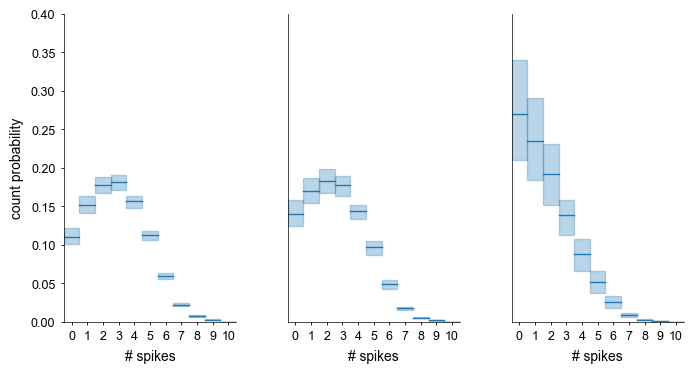

In [4]:
# histograms
lower, mean, upper = utils.signal.percentiles_from_samples(P_mc, [0.05, 0.5, 0.95])


fig = plt.figure(figsize=(8, 4))
widths = [1, 1, 1]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, wspace=0.3)

ne = 2  # select neuron
K = P_mc.shape[-1]
for en, step_ind in enumerate([50, 55, 60]):
    ax = fig.add_subplot(spec[0, en])
    hd = hd_sweep[step_ind]
    #ax.set_title(r'$\theta_{hd} = $' + '{:.1f}'.format(hd / np.pi * 180) + r'$^{\circ}$')
    
    for k in range(K):
        XX_ = np.linspace(k-0.5, k+0.5, 2)
        YY_ = np.ones(2)*mean.numpy()[ne, step_ind, k]
        YY_l = np.ones(2)*lower.numpy()[ne, step_ind, k]
        YY_u = np.ones(2)*upper.numpy()[ne, step_ind, k]
        line, = ax.plot(XX_, YY_, c='tab:blue', alpha=1.)
        ax.fill_between(XX_, YY_l, 
            YY_u, color=line.get_color(), alpha=0.3)


    ax.set_xlim([-0.5, K-1+.5])
    ax.set_ylim(0, 0.4)
    ax.set_xticks(np.arange(K))
    ax.spines[['top', 'right']].set_visible(False)
    if en > 0:
        ax.set_yticks([])

    if en == 0:
        ax.set_ylabel('count probability', labelpad=5)
    ax.set_xlabel('# spikes', labelpad=5)

plt.show()
fig.savefig("/homes/vn283/UCM-interpret/figures/SCDs.pdf", format="pdf", bbox_inches="tight")

In [5]:
K = P_mc.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2
hd_FF = hd_var / (hd_mean + 1e-12)

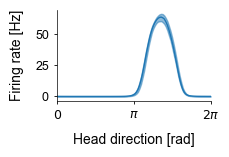

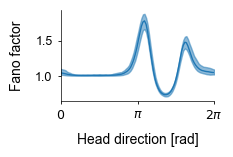

In [6]:
fig, ax = plt.subplots(figsize=(1.98,1.18))


lower, mean, upper = utils.signal.percentiles_from_samples(hd_rate, [0.05, 0.5, 0.95])
ne = 7  # select neuron to plot

line, = ax.plot(hd_sweep.numpy(), mean[ne, :].numpy())
ax.fill_between(
    hd_sweep.numpy(), lower[ne, :].numpy(), upper[ne, :].numpy(), 
    color=line.get_color(), alpha=0.5
)
ax.set_ylabel('Firing rate [Hz]')
ax.set_xlabel('Head direction [rad]')
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
ax.spines[['top', 'right']].set_visible(False)
plt.show()
fig.savefig("/homes/vn283/UCM-interpret/figures/mean_tc.pdf", format="pdf", bbox_inches="tight")


fig, ax = plt.subplots(figsize=(1.98,1.18))

lower, mean, upper = utils.signal.percentiles_from_samples(hd_FF, [0.05, 0.5, 0.95])

line, = ax.plot(hd_sweep.numpy(), mean[ne, :].numpy())
ax.fill_between(
    hd_sweep.numpy(), lower[ne, :].numpy(), upper[ne, :].numpy(), 
    color=line.get_color(), alpha=0.5
)
ax.set_ylabel('Fano factor')
ax.set_xlabel('Head direction [rad]')
ax.set_xlim(0, 2*np.pi)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
ax.spines[['top', 'right']].set_visible(False)

plt.show()
fig.savefig("/homes/vn283/UCM-interpret/figures/ff_tc.pdf", format="pdf", bbox_inches="tight")